### Installing Modules

In [1]:
import pandas as pd,numpy as np
from sklearn.cluster import DBSCAN
from ai_patterns_mining import Config
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from ai_patterns_mining import parse_json_safe
import getpass,os
from langchain.chat_models import init_chat_model
from tqdm import tqdm
from sklearn.preprocessing import normalize
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.mixture import BayesianGaussianMixture

/home/hasinthaka/Documents/Projects/AI/Pattern Mining/pipeline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config(tag="prompt & rag",run_output="20251028_085918 - Run ")

In [3]:
base_data = pd.read_csv(config.PATTERN_EMBEDDINGS_FILE)
data = pd.read_csv("./data.csv")

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,3068,3069,3070,3071,Pattern Name,Problem,Context,Solution,Result,Uses
0,-0.024275,0.012078,0.025686,-0.063131,0.003710,-0.007048,-0.001672,0.018050,0.006669,-0.008491,...,-0.015671,-0.011891,-0.014390,0.007197,Tool-Augmented Foundation Model,Foundation models (including LLMs) are inheren...,While foundation models possess powerful natur...,Enhance foundation models' capabilities by equ...,Foundation models can transcend their inherent...,Accessing contemporary or real-time informatio...
1,-0.008191,0.003771,0.017525,-0.069466,0.005526,0.004902,0.018165,0.018313,0.009491,-0.005704,...,-0.018045,-0.007270,-0.003900,-0.009526,Domain-Specific Tool Integration,"LLMs, trained on general knowledge, often exhi...",LLMs needing to perform tasks requiring deep e...,Employ specific external tools like online cal...,"Mitigates the expertise gap in LLMs, enhancing...","Performing complex calculations, solving equat..."
2,-0.001247,0.011756,0.010845,-0.064622,0.007938,-0.014040,0.001880,0.026454,-0.003862,-0.004009,...,-0.012774,-0.009557,-0.001842,-0.003681,Task Automation via Tools,LLMs are fundamentally language processors and...,Users requiring LLMs to perform real-world act...,Integrate LLMs with external task automation t...,LLMs can facilitate the execution of external ...,"Scheduling appointments, setting reminders, fi..."
3,-0.025640,0.017146,0.008126,-0.085418,0.008393,0.001277,-0.006190,0.023205,0.011792,-0.012512,...,-0.016213,-0.006697,-0.011836,-0.025644,Multimodal Interaction Augmentation,LLMs often struggle to consistently understand...,User interactions involving varied input types...,Deploy specialized tools like speech recogniti...,Improved understanding and response to a broad...,"Understanding speech inputs, analyzing images,..."
4,-0.027161,0.018188,0.022234,-0.068988,0.008201,-0.013026,-0.015420,0.039391,0.007960,0.003362,...,-0.007785,-0.010598,0.009240,0.006855,Transparent Tool-Use Reasoning,The opaque 'black-box' nature of current LLMs ...,"LLM applications where interpretability, accou...",Utilize tool learning to enable LLMs to exhibi...,"More transparent LLM operations, allowing user...","Explaining complex problem-solving steps, debu..."


In [5]:
pattern_cols = ["Pattern Name","Problem","Context","Solution","Result","Uses"]
features_cols = [i for i in data.columns.tolist() if i not in pattern_cols]
embeddings = data[features_cols]
patterns_data = data[pattern_cols]
Y = data["Pattern Name"].tolist()

In [6]:
base_embeddings_norm = normalize(base_data[features_cols], norm='l2')
embeddings_norm = normalize(embeddings, norm='l2')

### Model Defining & LLMs configuration

In [7]:
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0)

In [8]:
llm.invoke("Hello, Gemini!")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--6fd6cd39-560d-4821-8208-72159130f7e6-0', usage_metadata={'input_tokens': 5, 'output_tokens': 471, 'total_tokens': 476, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 462}})

In [9]:
pattern_comparing_prompt = """\
You are an expert in AI design pattern analysis and comparison.

Compare the following two AI design patterns and determine whether to keep, remove, or combine them. 
Focus on identifying overlap, uniqueness, and usefulness in practical AI system design.

Pattern 01:
{pattern1}

Pattern 02:
{pattern2}

Respond strictly in the following JSON format:

  "remove": "pattern 01" | "pattern 02" | "both" | "none",
  "can_combine": true | false,
  "combined_pattern_suggestion":
    "Pattern Name": "<string>",
    "Problem": "<string>",
    "Context": "<string>",
    "Solution": "<string>",
    "Result": "<string>",
    "Uses": "<string>"
  ,
  "think": "<reasoning for the decision>"

**Decision rules:**
- If both patterns are valuable and distinct → `"remove": "none"`, `"can_combine": false`.
- If both patterns describe the same thing but one is more comprehensive → remove the less useful one. => `"remove": "pattern 01"` or `"remove": "pattern 02"`. can_combine: false.
- If one pattern is redundant or weaker → remove the less useful one.
- If both are address same concept in different ways and can merge into a stronger unified pattern → `"remove": "both"`, `"can_combine": true`.
- If both solve different problems or contexts → `"remove": "none"`.
- Prefer keeping existing patterns rather than creating new combined ones.
- Only include `combined_pattern_suggestion` if `"can_combine": true`; otherwise, leave it empty or omit it.
- Do not include any explanation outside the JSON output.

"""

pattern_comparing_prompt = pattern_comparing_prompt.replace("""\"think": "<reasoning for the decision>\"""", "")

In [10]:
def compare_patterns(pattern1, pattern2):
    log_file = "./logs/pattern_comparison_log.txt"
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    f = open(log_file,"a")
    f.write("="*100+f"\nComparing Patterns:\nPattern 01: {pattern1}\nPattern 02: {pattern2}\n")
    prompt = pattern_comparing_prompt.format(pattern1=pattern1, pattern2=pattern2)
    response = llm.invoke(prompt)
    f.write(f"LLM Response: {response.content}\n\n")
    return parse_json_safe(response.content,delimiter="{}")

In [11]:
def df_to_pattern_dict(df):
    return {
        "Pattern Name": df["Pattern Name"].values[0],
        "Problem": df["Problem"].values[0],
        "Context": df["Context"].values[0],
        "Solution": df["Solution"].values[0],
        "Result": df["Result"].values[0],
        "Uses": df["Uses"].values[0],
    }

### Embedding Generation

In [12]:
def get_embedding_model():
    return GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

def generate_embeddings(texts):
    embedding_model = get_embedding_model()
    embeddings = embedding_model.embed_documents(texts)
    return embeddings

In [13]:
def pattern_combiner(patterns):
    combined_patterns = []

    for pattern in patterns:
        pattern_text = f"<PatternName>{pattern.get('Pattern Name', 'Unnamed Pattern')}</PatternName>\n"
        pattern_text += f"<Problem>{pattern.get('Problem', '')}</Problem>\n"
        pattern_text += f"<Context>{pattern.get('Context', '')}</Context>\n"
        pattern_text += f"<Solution>{pattern.get('Solution', '')}</Solution>\n"
        pattern_text += f"<Result>{str(pattern.get('Result', ''))}</Result>\n"
        pattern_text += f"<Uses>\n"
        pattern_text += f"{str(pattern.get('Uses', []))}\n"
        pattern_text += f"</Uses>\n"
        combined_patterns.append(pattern_text)
    return combined_patterns

### Candidates Reduction

In [15]:
def reduce_candidates(cluster, iteration=1,data_size=None):
    cluster = cluster.reset_index(drop=True)
    if len(cluster) <= 1:
        return cluster
    if not data_size:
        data_size = cluster.shape[0]
    distances = pairwise_distances(cluster[features_cols], metric='cosine')
    to_remove = set()
    new_patterns = []

    for i, row in tqdm(enumerate(distances),desc="Candidate Reduction",ncols=80):
        neighbours = np.argsort(row)
        neighbours = neighbours[neighbours != i]
        closest_idx = next((idx for idx in neighbours if idx not in to_remove), None)
        if closest_idx is None:
            continue

        pattern_dict_01 = df_to_pattern_dict(cluster.iloc[[i]])
        pattern_dict_02 = df_to_pattern_dict(cluster.iloc[[closest_idx]])
        comparison_result = compare_patterns(pattern_dict_01, pattern_dict_02)

        decision = comparison_result.get("remove")
        if decision == "pattern 01":
            to_remove.add(i)
        elif decision == "pattern 02":
            to_remove.add(closest_idx)
        elif decision == "both" and comparison_result.get("can_combine"):
            combined_pattern = comparison_result.get("combined_pattern_suggestion")
            if combined_pattern:
                new_patterns.append(combined_pattern)
            to_remove.update({i, closest_idx})

    keep_mask = np.ones(len(cluster), dtype=bool)
    if to_remove:
        keep_idx = sorted(set(range(len(cluster))) - to_remove)
        keep_mask[:] = False
        keep_mask[keep_idx] = True

    reduced_cluster = cluster.loc[keep_mask].reset_index(drop=True)

    if new_patterns:
        new_embeddings = generate_embeddings(pattern_combiner(new_patterns))
        new_rows = []
        for embedding_vec, pattern_info in zip(new_embeddings, new_patterns):
            row = {col: pattern_info.get(col) for col in pattern_cols}
            row.update({col: value for col, value in zip(features_cols, embedding_vec)})
            new_rows.append(row)
        new_rows_df = pd.DataFrame(new_rows, columns=cluster.columns)
        reduced_cluster = pd.concat([reduced_cluster, new_rows_df], ignore_index=True)

    if len(reduced_cluster) <= 1 or iteration >= 3:
        return reduced_cluster

    distances = pairwise_distances(reduced_cluster[features_cols], metric='cosine')
    # should_adjust = False
    # for row in distances:
    #     positives = row[row > 0]
    #     if positives.size and positives.min() < 0.05:
    #         should_adjust = True
    #         break

    if reduced_cluster.shape[0] > 1 and reduced_cluster.shape[0] < data_size:
        print(f"Iteration {iteration+1}")
        return reduce_candidates(reduced_cluster, iteration=iteration + 1)

    return reduced_cluster

### Clustering

In [7]:
def build_cluster_chart(eps=0.08,min_samples=1, metric='cosine', emb=embeddings, tag=""):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    clusters = dbscan.fit_predict(emb)
    print("EPS:", eps, " / Min Samples:", min_samples, " / No of clusters:", len(set(clusters.tolist())))

    plt.figure(figsize=(10,6))
    sns.countplot(x=clusters)
    plt.title(f"Cluster Distribution {tag} (eps={eps}, min_samples={min_samples})")
    plt.xlabel("Cluster Label")
    plt.ylabel(f"Number of Patterns (Total: {len(emb)})")
    plt.show()

In [16]:
def cluster_and_reduce_candidates(eps=0.08,cluster_view_only=False, min_samples=1, metric='cosine', data=data, tag=""):
    emb = data[features_cols]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    clusters = dbscan.fit_predict(emb)
    print("Number of clusters found:", len(set(clusters.tolist())))

    # plt.figure(figsize=(10,6))
    # sns.countplot(x=clusters)
    # plt.title(f"Cluster Distribution {tag} (eps={eps}, min_samples={min_samples})")
    # plt.xlabel("Cluster Label")
    # plt.ylabel(f"Number of Patterns (Total: {len(emb)})")
    # plt.show()

    clustered = data.copy()
    clustered["cluster"] = clusters

    collected_groups = []

    for name, group in tqdm(clustered.groupby("cluster"),desc="Cluster",ncols=80):
        cluster_df = group.drop(columns=["cluster"]).reset_index(drop=True)
        if cluster_df.empty:
            continue

        if len(cluster_df) <= 1:
            collected_groups.append(cluster_df)
            continue
        print("Cluster Patterns")
        for _, row in group.iterrows():
            print(f" - {row['Pattern Name']}")
        print()
        if cluster_view_only:
            collected_groups.append(cluster_df)
            continue
        reduced_patterns = reduce_candidates(cluster_df)
        collected_groups.append(reduced_patterns.reset_index(drop=True))
        print("Reduced to")
        for _, row in reduced_patterns.iterrows():
            print(f" - {row['Pattern Name']}")
        print()

    if not collected_groups:
        return pd.DataFrame(columns=data.columns)

    return pd.concat(collected_groups, ignore_index=True)

In [42]:
iteration_01 = cluster_and_reduce_candidates(0.032,data=data, cluster_view_only=True)

Number of clusters found: 288


Cluster: 100%|███████████████████████████████| 288/288 [00:00<00:00, 492.21it/s]


In [43]:
iteration_02 = cluster_and_reduce_candidates(0.045,data=iteration_01, cluster_view_only=True)

Number of clusters found: 288


Cluster: 100%|███████████████████████████████| 288/288 [00:00<00:00, 530.25it/s]


In [44]:
iteration_03 = cluster_and_reduce_candidates(0.05,data=iteration_02, cluster_view_only=True)

Number of clusters found: 287


Cluster:  88%|███████████████████████████▎   | 253/287 [00:00<00:00, 657.40it/s]

Cluster Patterns
 - Zero-Shot LM Reranking
 - Predictive Reranking (Trained LM-Dedicated Reranker)



Cluster: 100%|███████████████████████████████| 287/287 [00:00<00:00, 607.39it/s]


In [45]:
iteration_04 = cluster_and_reduce_candidates(0.05,data=iteration_03, cluster_view_only=True)

Number of clusters found: 287


Cluster:  66%|████████████████████▍          | 189/287 [00:00<00:00, 422.11it/s]

Cluster Patterns
 - Zero-Shot LM Reranking
 - Predictive Reranking (Trained LM-Dedicated Reranker)



Cluster: 100%|███████████████████████████████| 287/287 [00:00<00:00, 451.72it/s]


In [46]:
iteration_05 = cluster_and_reduce_candidates(0.06,data=iteration_04, cluster_view_only=True)

Number of clusters found: 285


Cluster:   0%|                                          | 0/285 [00:00<?, ?it/s]

Cluster:  70%|█████████████████████▊         | 200/285 [00:00<00:00, 552.73it/s]

Cluster Patterns
 - Retrieval Stride Optimization
 - Retrieval Query Length Optimization
 - Optimal Document Count for In-Context Learning

Cluster Patterns
 - Zero-Shot LM Reranking
 - Predictive Reranking (Trained LM-Dedicated Reranker)



Cluster: 100%|███████████████████████████████| 285/285 [00:00<00:00, 540.91it/s]


In [48]:
iteration_06 = cluster_and_reduce_candidates(0.07,data=iteration_05, cluster_view_only=True)

Number of clusters found: 259


Cluster:   0%|                                          | 0/259 [00:00<?, ?it/s]

Cluster:  11%|███▌                            | 29/259 [00:00<00:00, 280.08it/s]

Cluster Patterns
 - Task Decomposition and Planning
 - Orchestrated Decomposition
 - Tool Orchestration / Chaining

Cluster Patterns
 - LLM as Tool Maker/Creator
 - AI Tool Creation

Cluster Patterns
 - Retrieval Augmented Generation (RAG) with Transparent and Dynamically Updatable Knowledge
 - InContext Retrieval-Augmented Language Modeling (InContext RALM)

Cluster Patterns
 - Adaptive Iterative Retrieval-Augmented Generation (Adaptive Iterative RAG)
 - Adaptive Retrieval-Augmented Generation (AdaptiveRAG)

Cluster Patterns
 - Reasoning on Graphs (RoG) / Planning-Retrieval-Reasoning Framework
 - ThinkonGraph (ToG) Algorithmic Framework for LLM-Guided KG Reasoning
 - Instruction Tuning for LLM-KG Integration
 - Unified Retrieval and Reasoning
 - LLM-KG Tight-Coupling Paradigm

Cluster Patterns
 - Multilevel Dynamic Knowledge Caching with Cache-Aware Request Scheduling for RAG
 - Knowledge Tree for RAG KV Cache

Cluster Patterns
 - Tool Understanding (via Prompting)
 - In-Context Learn

Cluster:  31%|██████████                      | 81/259 [00:00<00:00, 200.62it/s]

Cluster Patterns
 - Reflexion
 - Reflexion

Cluster Patterns
 - Distractor-Aware Robustness Training for RAG
 - Retrieval Augmented Fine-Tuning (RAFT)

Cluster Patterns
 - Tool-Integrated Reasoning Agent (TORA)
 - Tool-Integrated Reasoning Agent (ToRA)

Cluster Patterns
 - Interactive Tool Use Trajectory Curation
 - Few-Shot Prompting for Structured Trajectory Generation

Cluster Patterns
 - Output Space Shaping
 - Teacher-Assisted Trajectory Correction



Cluster:  39%|████████████▏                  | 102/259 [00:00<00:00, 189.21it/s]

Cluster Patterns
 - End-to-End Retriever Training (for RAG Domain Adaptation)
 - End-to-End Joint Training (Retriever-Generator)

Cluster Patterns
 - Retrieval Stride Optimization
 - Retrieval Query Length Optimization
 - Optimal Document Count for In-Context Learning

Cluster Patterns
 - Zero-Shot LM Reranking
 - Predictive Reranking (Trained LM-Dedicated Reranker)



Cluster:  77%|███████████████████████▊       | 199/259 [00:00<00:00, 236.27it/s]

Cluster Patterns
 - SelfRefine
 - Iterative Self-Correction with Automated Feedback

Cluster Patterns
 - XLT Cross-Lingual Thought Prompting
 - Cross-Lingual Self Consistent Prompting (CLSP)
 - InCLT Crosslingual Transfer Prompting



Cluster:  97%|█████████████████████████████▉ | 250/259 [00:01<00:00, 239.03it/s]

Cluster Patterns
 - Batch Prompting (for Evaluation)
 - Batch Prompting for Pruning

Cluster Patterns
 - LLMs as Knowledge Base
 - LLMs as Content Interpreter
 - LLMs for Direct Recommendation (In-context Learning & CoT)
 - LLMs as Conversational Agent



Cluster: 100%|███████████████████████████████| 259/259 [00:01<00:00, 220.95it/s]


Cluster Patterns
 - RAGSequence
 - RAGToken

Cluster Patterns
 - Thorough Decoding (RAGSequence)
 - Fast Decoding (RAGSequence)



In [37]:
iteration_05.to_csv('./data.csv', index=False)

EPS: 0.06  / Min Samples: 1  / No of clusters: 283


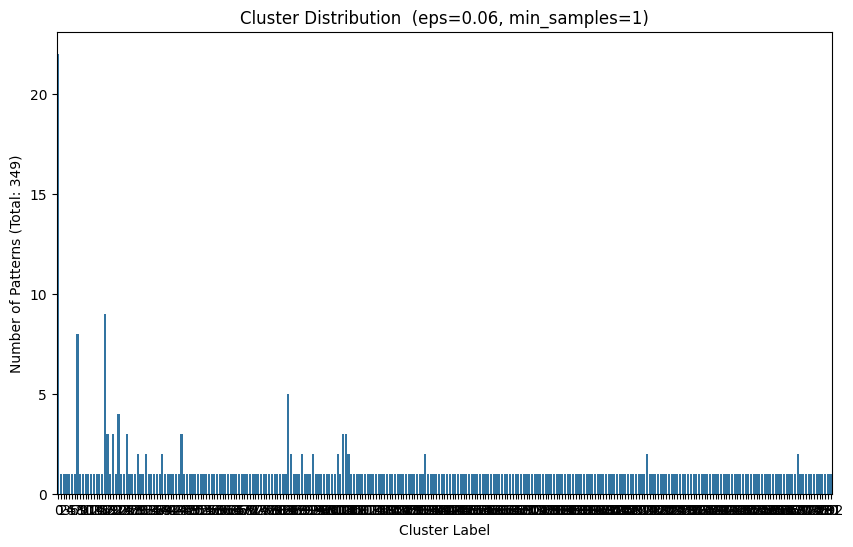

EPS: 0.06  / Min Samples: 1  / No of clusters: 283


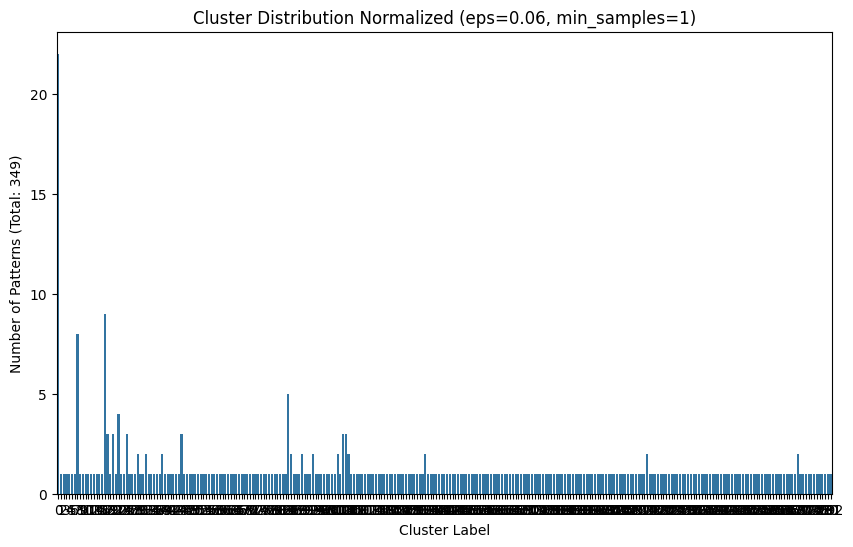

In [53]:
build_cluster_chart(eps=0.06,min_samples=1,emb=base_data[features_cols], tag="")
build_cluster_chart(eps=0.06,min_samples=1,emb=base_embeddings_norm, tag="Normalized")

In [8]:
def build_cluster_chart_with_sub(eps=0.08,min_samples=1, metric='cosine', data=data, tag=""):
    emb = data[features_cols]
    ptn = data[pattern_cols]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    clusters = dbscan.fit_predict(emb)
    print("EPS:", eps, " / Min Samples:", min_samples, " / No of clusters:", len(set(clusters.tolist())))

    # plt.figure(figsize=(10,6))
    # sns.countplot(x=clusters)
    # plt.title(f"Cluster Distribution {tag} (eps={eps}, min_samples={min_samples})")
    # plt.xlabel("Cluster Label")
    # plt.ylabel(f"Number of Patterns (Total: {len(emb)})")
    # plt.show()
    new_df = data.copy()
    new_df['cluster'] = clusters
    zero_cluster_df = new_df[new_df["cluster"]==0]
    return new_df



In [9]:
first_itter = build_cluster_chart_with_sub(eps=0.105,data=base_data)
final_itter = build_cluster_chart_with_sub(eps=0.09,data=first_itter.loc[first_itter['cluster']==0])
first_itter.loc[first_itter["cluster"]!=0,"cluster"] += len(final_itter['cluster'].unique())-1
first_itter.loc[first_itter["cluster"]==0,"cluster"] = final_itter["cluster"].values

dbscan_clustered_df = first_itter

EPS: 0.105  / Min Samples: 1  / No of clusters: 40
EPS: 0.09  / Min Samples: 1  / No of clusters: 62


In [10]:
emb = base_data[features_cols]
kmeans = KMeans(n_clusters=101, random_state=42)
clusters = kmeans.fit_predict(emb)
kmeans_clustered_df = base_data.copy()
kmeans_clustered_df['cluster'] = clusters
print("No of clusters:", len(set(clusters.tolist())))

No of clusters: 101


In [11]:
emb = base_data[features_cols]
model = BayesianGaussianMixture(
    n_components=101,
    covariance_type='full',
    random_state=42
)
clusters = model.fit_predict(emb)
gaussian_clustered_df = base_data.copy()
gaussian_clustered_df['cluster'] = clusters
print("No of clusters:", len(set(clusters.tolist())))

No of clusters: 101


In [14]:
def evaluate_clustering(labels1, labels2):
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)

    print("Adjusted Rand Index:", ari)
    print("Normalized Mutual Information:", nmi)

In [16]:
print("DBSCAN vs KMeans:")
evaluate_clustering(dbscan_clustered_df['cluster'].values, kmeans_clustered_df['cluster'].values)

print("\nDBSCAN vs Gaussian Mixture:")
evaluate_clustering(dbscan_clustered_df['cluster'].values, gaussian_clustered_df['cluster'].values)

print("\nKMeans vs Gaussian Mixture:")
evaluate_clustering(kmeans_clustered_df['cluster'].values, gaussian_clustered_df['cluster'].values)

DBSCAN vs KMeans:
Adjusted Rand Index: 0.017186742206310703
Normalized Mutual Information: 0.5609709980906378

DBSCAN vs Gaussian Mixture:
Adjusted Rand Index: 0.017186742206310703
Normalized Mutual Information: 0.5609709980906378

KMeans vs Gaussian Mixture:
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


In [30]:
gaussian_groups

{0: [130], 1: [21, 34, 106, 152, 185, 187, 263], 2: [205, 294, 296, 299, 302], 3: [107, 108, 109, 110, 111, 137, 138], 4: [133, 340, 348], 5: [219], 6: [25, 26, 98, 188, 189], 7: [11, 77, 151, 157, 210], 8: [182, 201, 202, 218], 9: [65], 10: [31, 50, 63, 105, 145, 155, 245, 249, 293, 301], 11: [15, 23, 57, 140, 291], 12: [32, 275], 13: [259], 14: [305, 313], 15: [229, 230], 16: [266, 267], 17: [42, 44], 18: [18, 24, 52, 92, 116, 148, 173, 177, 209, 289], 19: [154, 322, 326], 20: [36, 280, 297], 21: [117, 118, 190, 238], 22: [90, 158, 311], 23: [74, 75, 86, 114, 115, 119, 120, 122, 150, 321], 24: [174, 176, 178, 183, 184, 191, 199, 211, 272], 25: [19, 46, 54, 56, 68], 26: [2, 8, 9, 89, 104, 146, 320], 27: [256, 257, 273, 319], 28: [16, 215, 250, 251, 252, 253, 254, 268, 270, 318, 333], 29: [28, 93, 147, 241], 30: [4, 69, 70, 71, 78, 79, 80, 81, 82, 88], 31: [97, 99, 102], 32: [39, 40], 33: [135, 136, 141, 143], 34: [223, 224], 35: [17, 193, 204, 255], 36: [7, 91, 101, 156], 37: [41], 38

In [32]:
gaussian_groups = {}

for name, group in gaussian_clustered_df.groupby('cluster'):
    if len(group) > 1:
        gaussian_groups[name] = group['Pattern Name'].tolist()

for name, group in dbscan_clustered_df.groupby('cluster'):
    if len(group) > 1:
        print(f"DBSCAN Cluster {name}: {len(group)} patterns")
        patterns = group['Pattern Name'].tolist()
        matching_gaussian_clusters = []
        for g_name, g_patterns in gaussian_groups.items():
            common_patterns = set(patterns).intersection(set(g_patterns))
            if common_patterns:
                matching_gaussian_clusters.append((g_name, len(common_patterns)))
        if matching_gaussian_clusters:
            print("  Matches with Gaussian clusters:")
            for g_name, common_count in matching_gaussian_clusters:
                print(f"    Gaussian Cluster {g_name}: {common_count} common patterns")
        else:
            print("  No matching Gaussian clusters found.")

DBSCAN Cluster 0: 227 patterns
  Matches with Gaussian clusters:
    Gaussian Cluster 1: 5 common patterns
    Gaussian Cluster 2: 4 common patterns
    Gaussian Cluster 3: 7 common patterns
    Gaussian Cluster 4: 3 common patterns
    Gaussian Cluster 6: 4 common patterns
    Gaussian Cluster 7: 4 common patterns
    Gaussian Cluster 8: 4 common patterns
    Gaussian Cluster 10: 9 common patterns
    Gaussian Cluster 11: 5 common patterns
    Gaussian Cluster 12: 2 common patterns
    Gaussian Cluster 14: 1 common patterns
    Gaussian Cluster 18: 8 common patterns
    Gaussian Cluster 19: 2 common patterns
    Gaussian Cluster 20: 3 common patterns
    Gaussian Cluster 21: 4 common patterns
    Gaussian Cluster 22: 3 common patterns
    Gaussian Cluster 23: 9 common patterns
    Gaussian Cluster 24: 7 common patterns
    Gaussian Cluster 25: 5 common patterns
    Gaussian Cluster 26: 6 common patterns
    Gaussian Cluster 29: 3 common patterns
    Gaussian Cluster 30: 9 common patte

In [22]:
[kmeans_clustered_df['cluster'].values == gaussian_clustered_df['cluster'].values]

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [23]:
[dbscan_clustered_df['cluster'].values == gaussian_clustered_df['cluster'].values]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [17]:
def save_cluster_results(dataframe, filename):
    cluster_result_folder = "./cluster_results/"
    os.makedirs(cluster_result_folder, exist_ok=True)
    dataframe = dataframe.sort_values(by=["cluster"]).reset_index(drop=True)
    dataframe[["Pattern Name", "cluster"]].to_csv(os.path.join(cluster_result_folder, filename), index=False)

In [18]:
def get_clusters_more_than(dataframe, min_size=2):
    cluster_counts = dataframe['cluster'].value_counts()
    valid_clusters = cluster_counts[cluster_counts >= min_size].index
    filtered_df = dataframe[dataframe['cluster'].isin(valid_clusters)].reset_index(drop=True)
    return filtered_df

In [19]:
save_cluster_results(get_clusters_more_than(dbscan_clustered_df), "dbscan_clusters.csv")
save_cluster_results(get_clusters_more_than(kmeans_clustered_df), "kmeans_clusters.csv")
save_cluster_results(get_clusters_more_than(gaussian_clustered_df), "gaussian_clusters.csv")


In [78]:
labels1 = [0, 1, 4, 1, 3, 2, 2, 2, 2, 2]
labels2 = [3, 1, 3, 3, 1, 1, 2, 2, 2, 2]

labels3 = [0, 0, 0, 1, 1, 1, 2, 2, 2, 2]
labels4 = [3, 3, 3, 2, 2, 2, 1, 1, 1, 1]

evaluate_clustering(labels1, labels2)
evaluate_clustering(labels3, labels4)

Adjusted Rand Index: 0.35797665369649806
Normalized Mutual Information: 0.5719201336463416
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


In [54]:
(first_itter['cluster'].unique())

array([  0,   1,   2,  62,  63,  64,  65,  66,   3,   4,   5,   6,   7,
         8,  67,   9,  10,  11,  12,  13,  14,  15,  16,  68,  17,  18,
        19,  20,  21,  22,  23,  69,  24,  25,  26,  70,  71,  72,  27,
        28,  73,  29,  30,  74,  75,  31,  32,  76,  33,  34,  35,  77,
        78,  79,  80,  81,  82,  36,  37,  38,  39,  40,  83,  41,  42,
        43,  44,  84,  85,  86,  87,  88,  89,  90,  91,  45,  46,  47,
        92,  93,  48,  49,  50,  94,  51,  95,  52,  96,  53,  54,  97,
        55,  56,  98,  57,  58,  59,  99,  60, 100,  61])

In [52]:
[i for i in range(102) if i not in first_itter['cluster'].values]

[101]

In [166]:
print([i for i in final_itter.groupby("cluster").size().sort_values(ascending=False).tolist() if i>1])
print(len([i for i in final_itter.groupby("cluster").size().sort_values(ascending=False).tolist() if i==1]))

[227, 6, 3, 2, 2, 2, 2, 2]
17


EPS: 0.08  / Min Samples: 1  / No of clusters: 179


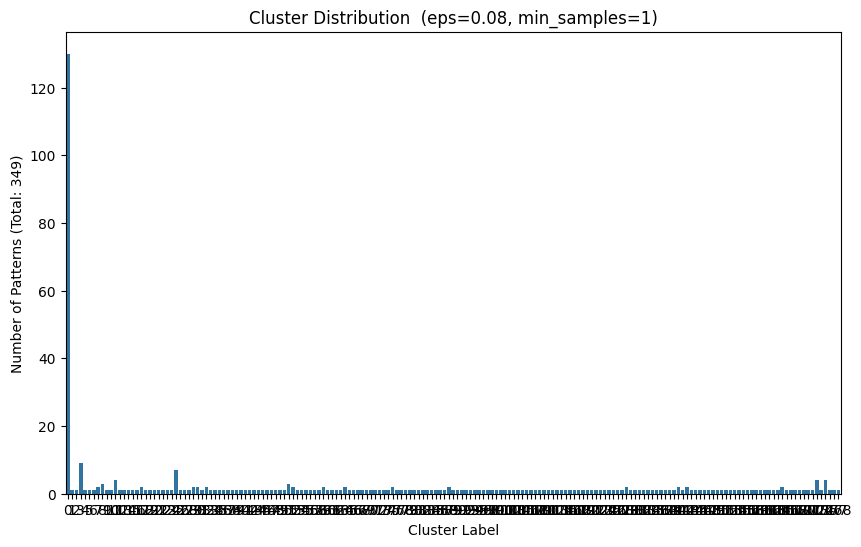

In [108]:
df = build_cluster_chart_with_sub(eps=0.08,min_samples=1,emb=base_data[features_cols], tag="")

In [109]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,cluster
0,-0.018883,0.018348,0.015192,-0.064823,0.009560,-0.000574,0.007251,0.018905,0.010347,0.005121,...,-0.001900,0.004805,-0.016298,0.015223,0.017728,-0.024357,-0.008189,0.007308,-0.005529,0
1,-0.008191,0.003771,0.017525,-0.069466,0.005526,0.004902,0.018165,0.018313,0.009491,-0.005704,...,-0.005885,0.003957,-0.015386,0.010565,0.015720,-0.018045,-0.007270,-0.003900,-0.009526,0
2,-0.001247,0.011756,0.010845,-0.064622,0.007938,-0.014040,0.001880,0.026454,-0.003862,-0.004009,...,-0.000190,0.004244,-0.022318,0.013288,0.024832,-0.012774,-0.009557,-0.001842,-0.003681,0
5,-0.018121,0.024662,0.016695,-0.072872,0.011399,-0.000701,0.000522,0.024080,0.006153,0.006112,...,-0.002858,-0.006236,-0.016313,0.014455,0.006776,-0.012445,-0.007517,-0.000909,-0.000619,0
7,-0.006119,0.013387,0.004193,-0.063149,0.001010,-0.010073,0.005017,0.031110,0.004942,-0.011252,...,0.002937,0.004022,-0.017545,0.019675,0.001815,-0.014816,-0.010231,-0.004869,-0.004189,0


EPS: 0.07  / Min Samples: 1  / No of clusters: 50


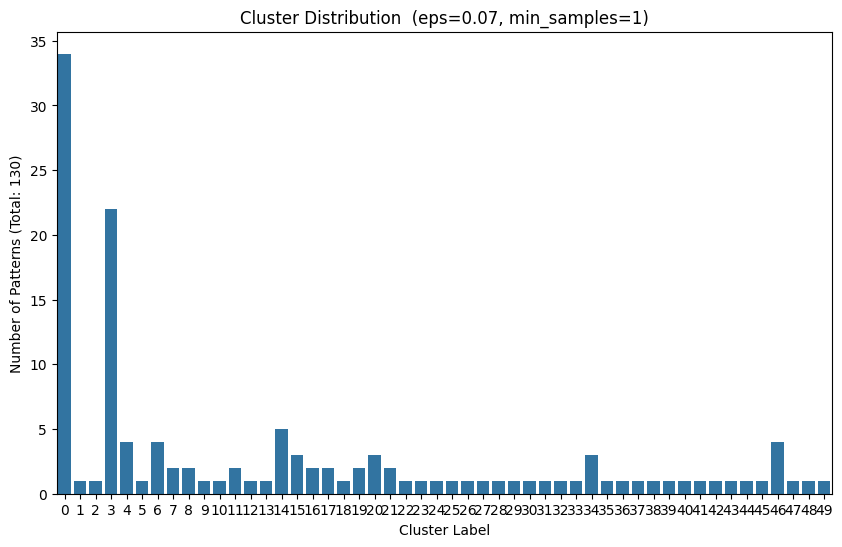

EPS: 0.07200000000000001  / Min Samples: 1  / No of clusters: 44


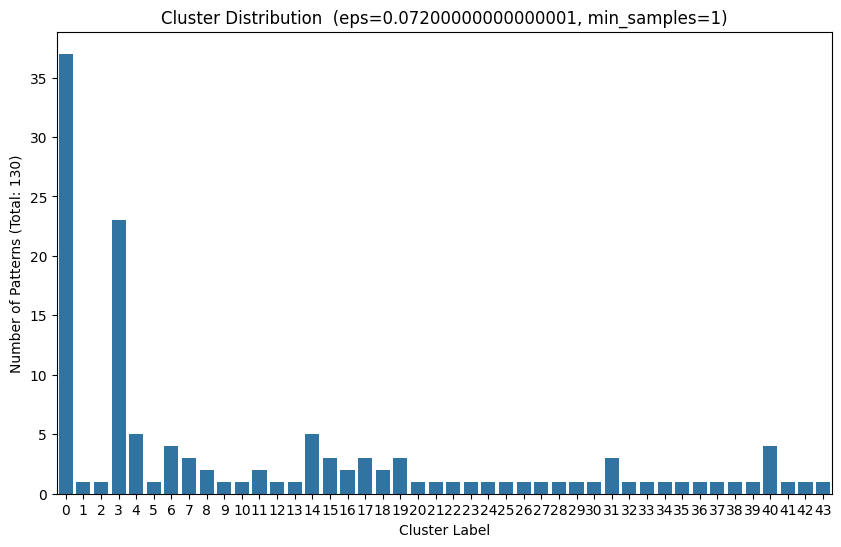

EPS: 0.07400000000000001  / Min Samples: 1  / No of clusters: 33


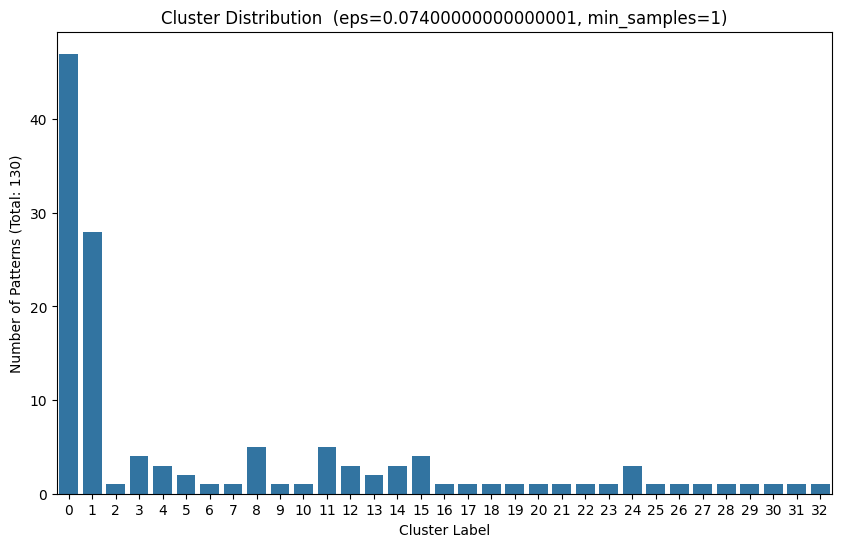

EPS: 0.07600000000000001  / Min Samples: 1  / No of clusters: 20


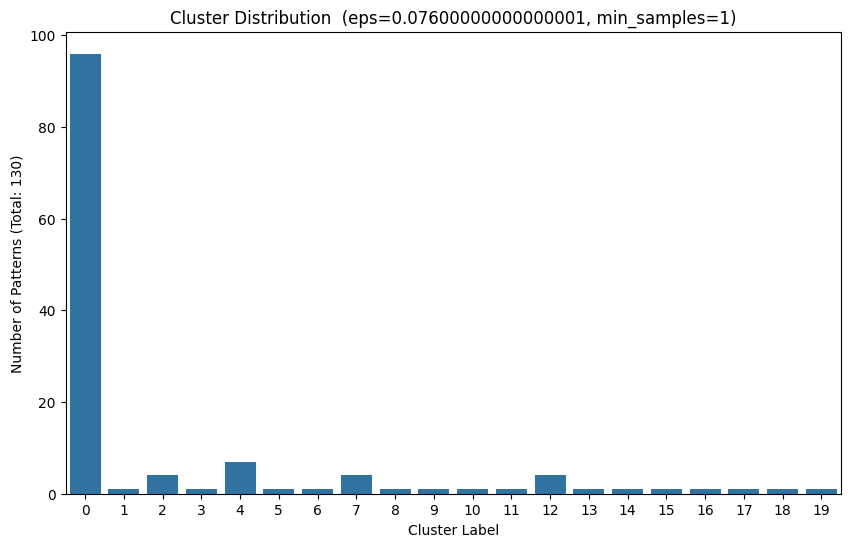

EPS: 0.07800000000000001  / Min Samples: 1  / No of clusters: 10


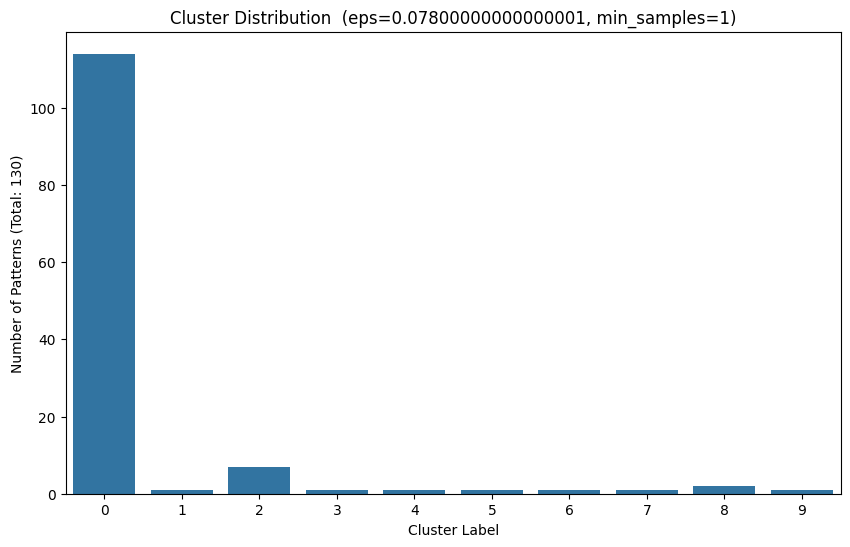

In [105]:
for i in range(5):
    build_cluster_chart_with_sub(eps=0.07+i*0.002,min_samples=1,emb=df, tag="")

EPS: 0.06  / Min Samples: 1  / No of clusters: 283


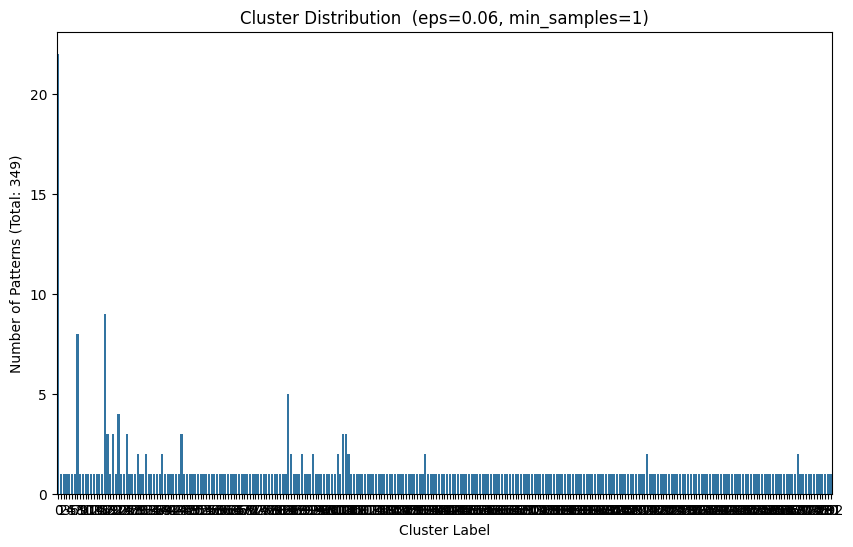

EPS: 0.06999999999999999  / Min Samples: 1  / No of clusters: 246


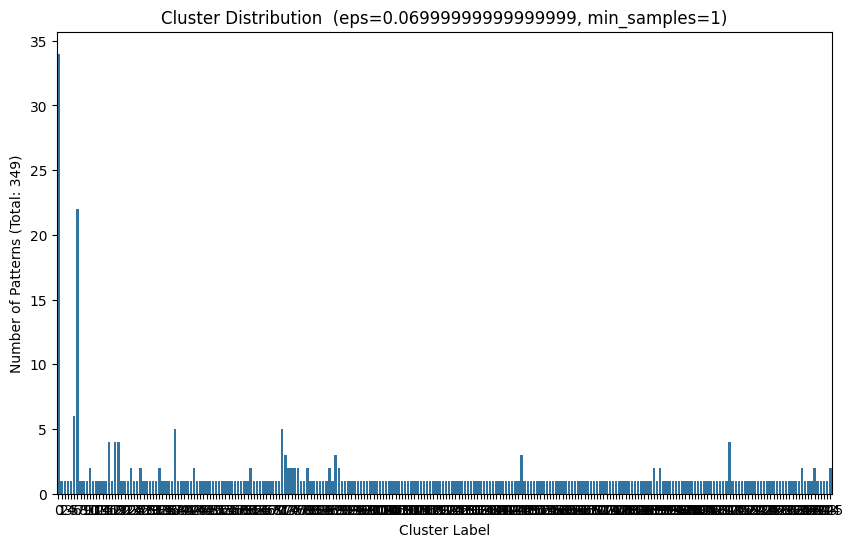

EPS: 0.08  / Min Samples: 1  / No of clusters: 179


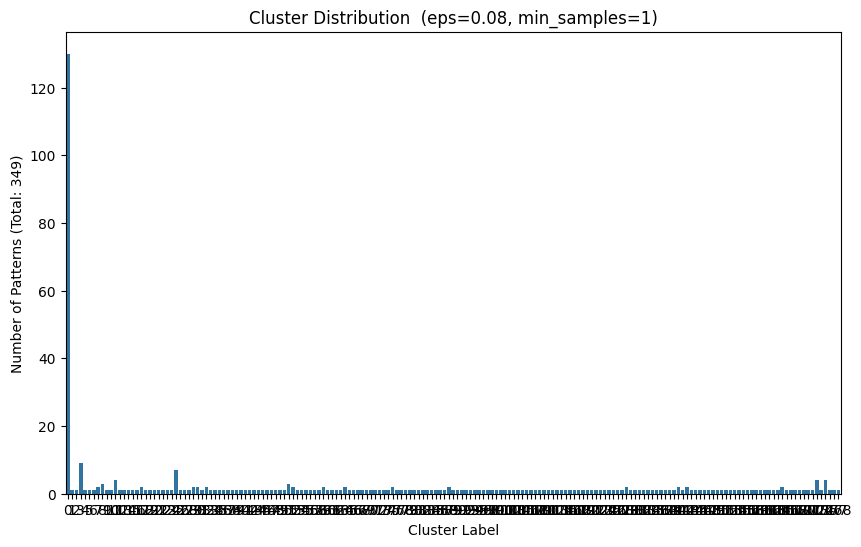

EPS: 0.09  / Min Samples: 1  / No of clusters: 105


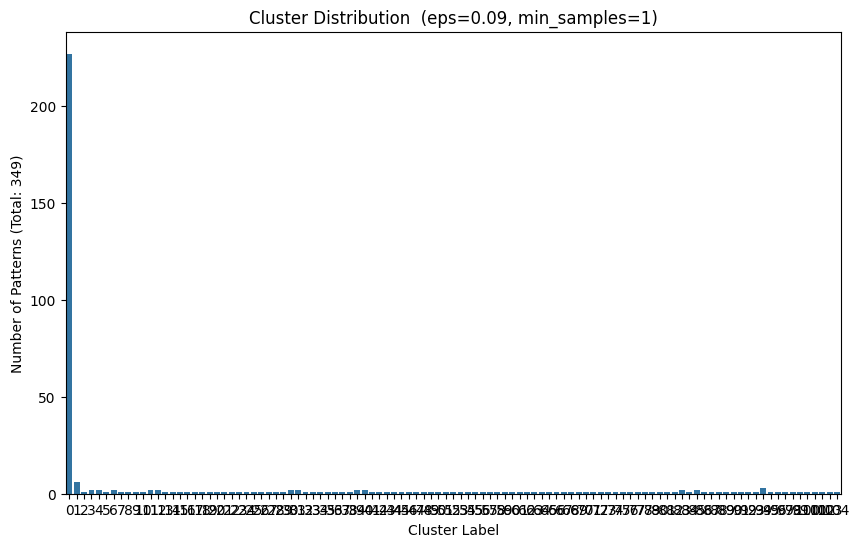

EPS: 0.1  / Min Samples: 1  / No of clusters: 53


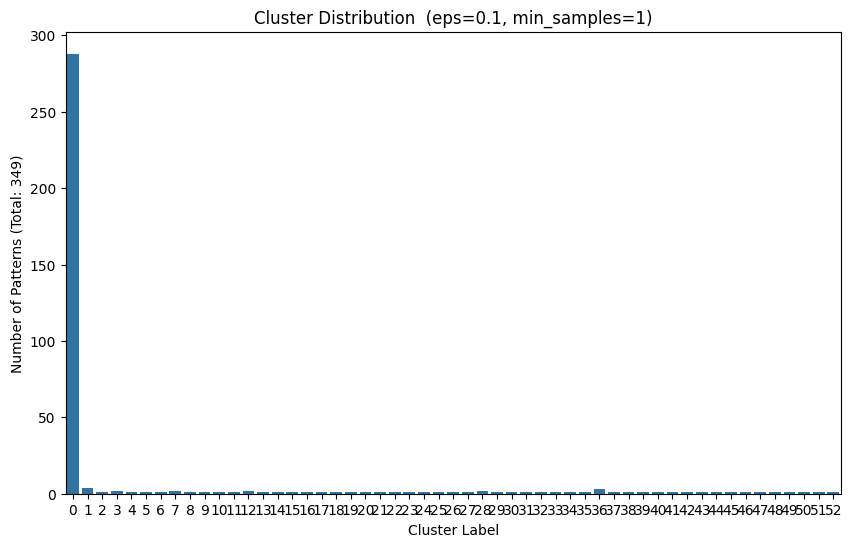

EPS: 0.11  / Min Samples: 1  / No of clusters: 29


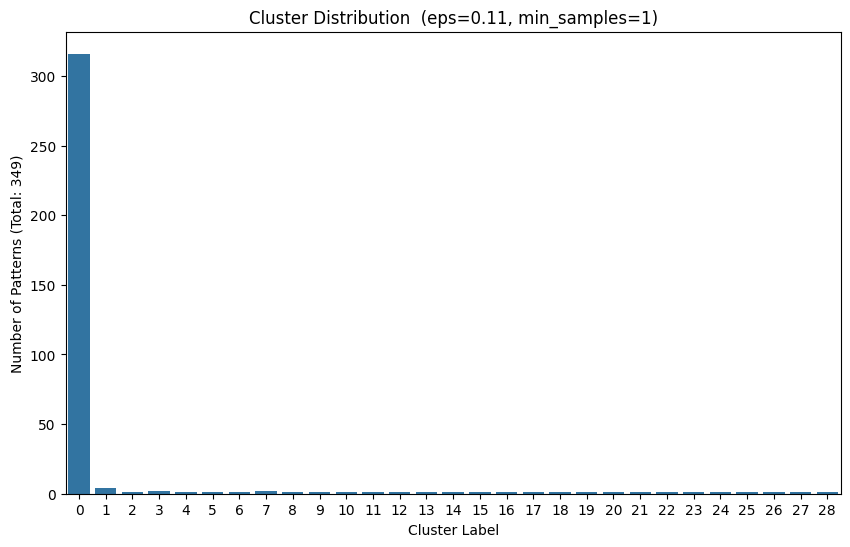

EPS: 0.12  / Min Samples: 1  / No of clusters: 12


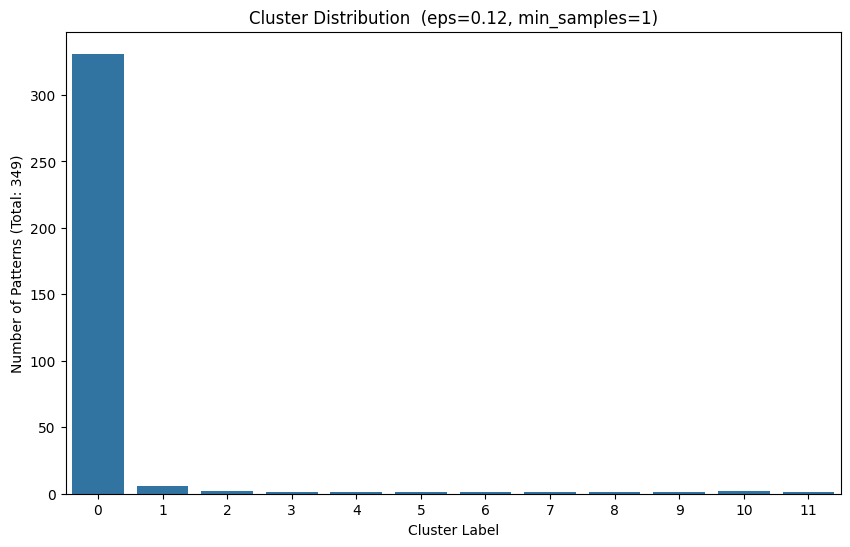

EPS: 0.13  / Min Samples: 1  / No of clusters: 4


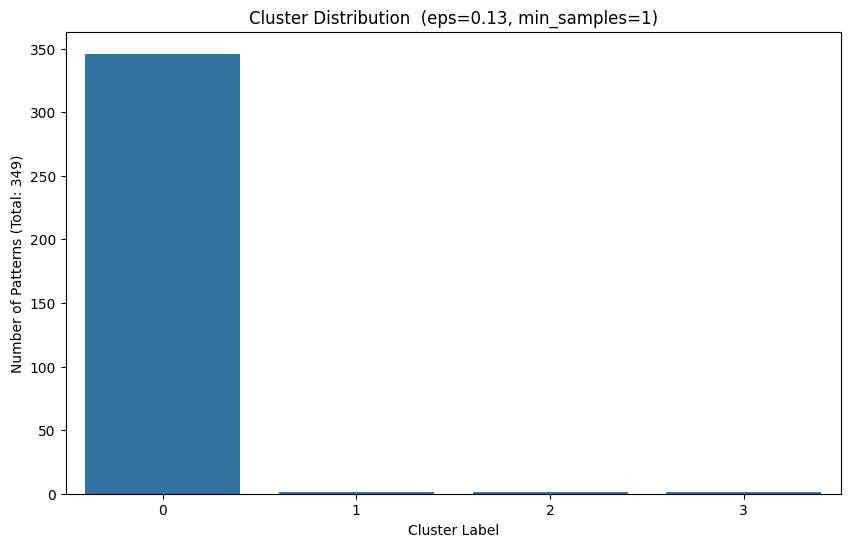

EPS: 0.14  / Min Samples: 1  / No of clusters: 1


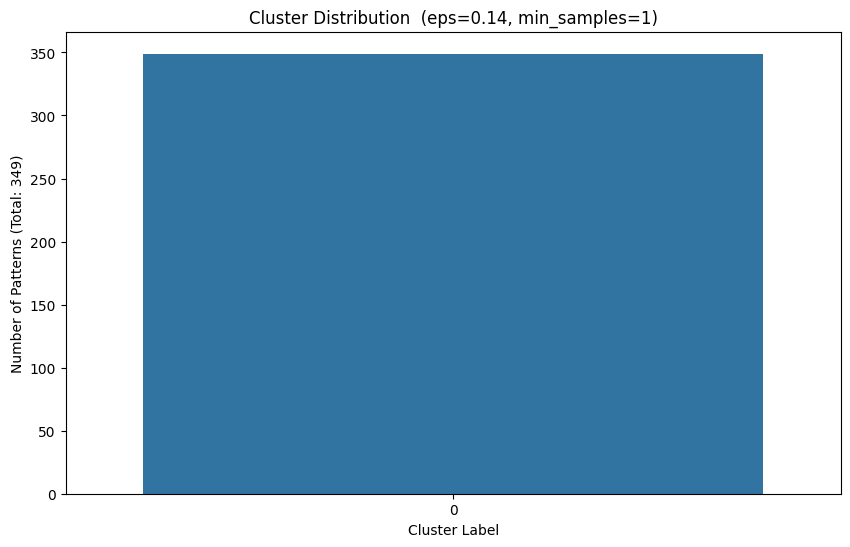

EPS: 0.15  / Min Samples: 1  / No of clusters: 1


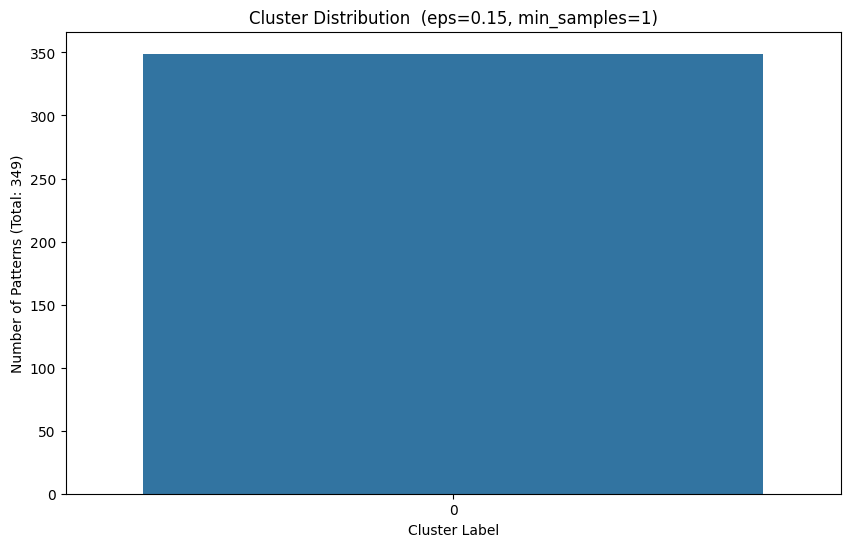

In [54]:
for i in range(10):
    build_cluster_chart(eps=0.06+i*0.01,min_samples=1,emb=base_data[features_cols], tag="")

EPS: 0.09  / Min Samples: 1  / No of clusters: 105


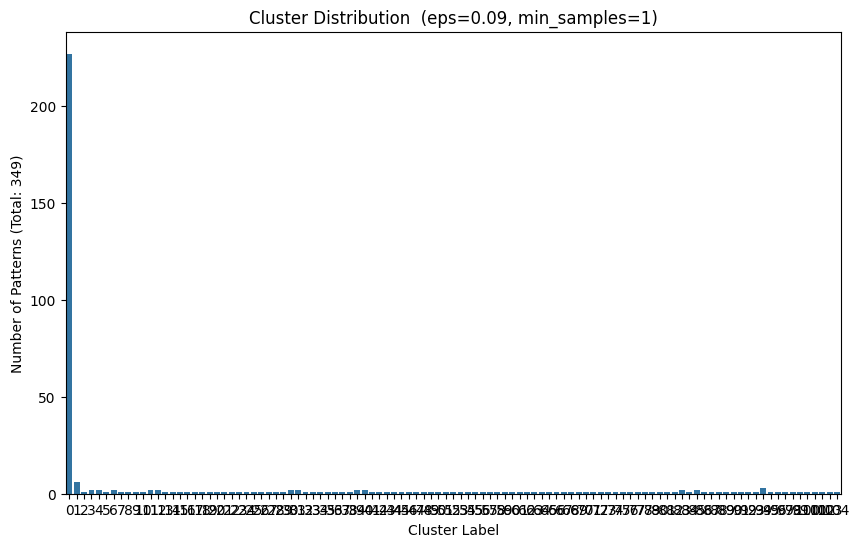

EPS: 0.095  / Min Samples: 1  / No of clusters: 75


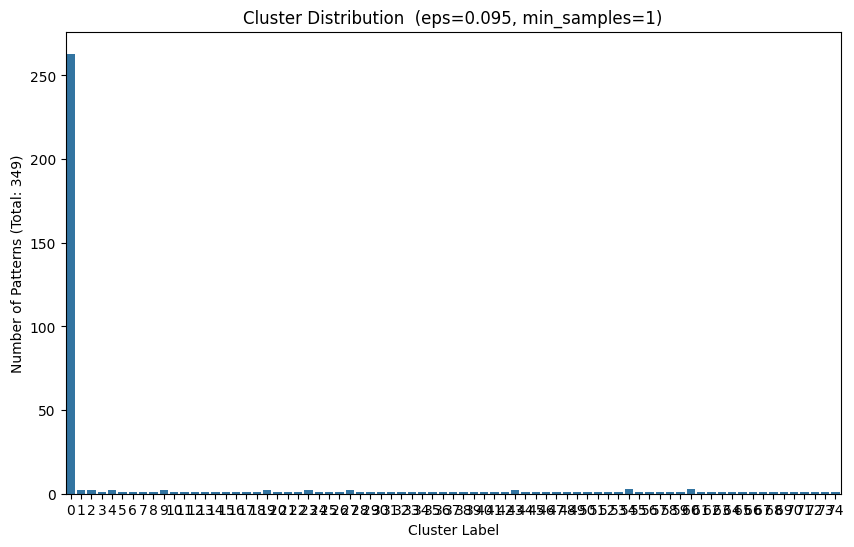

EPS: 0.09999999999999999  / Min Samples: 1  / No of clusters: 53


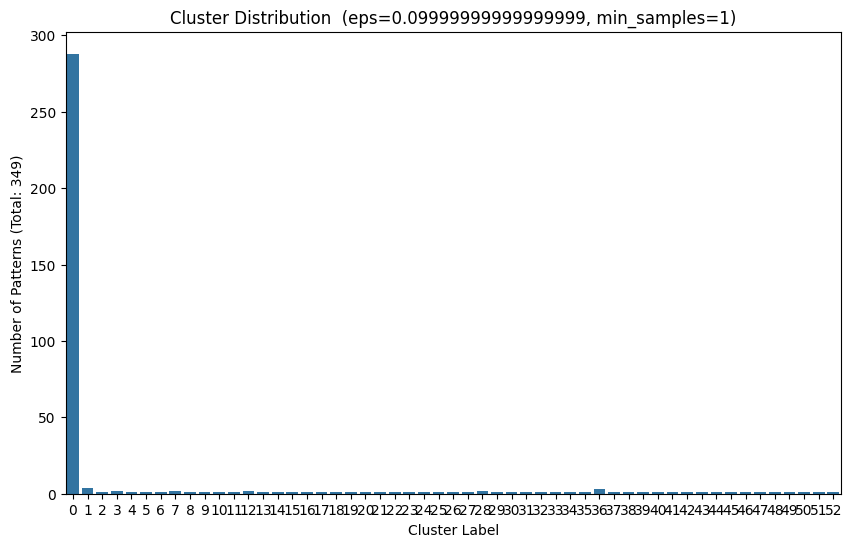

EPS: 0.105  / Min Samples: 1  / No of clusters: 40


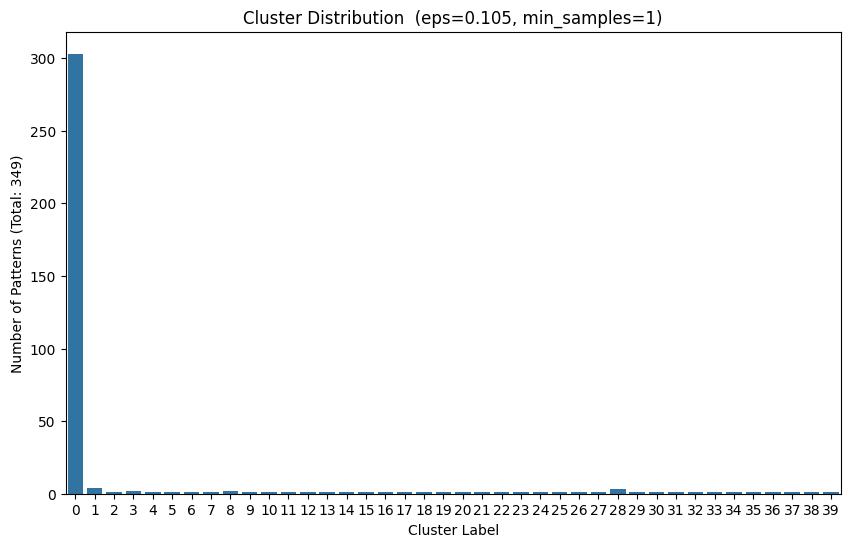

EPS: 0.11  / Min Samples: 1  / No of clusters: 29


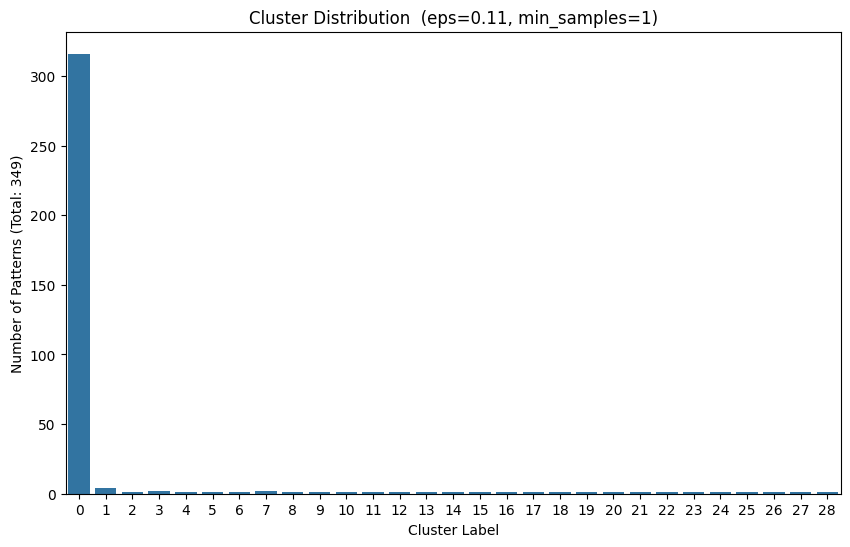

EPS: 0.11499999999999999  / Min Samples: 1  / No of clusters: 20


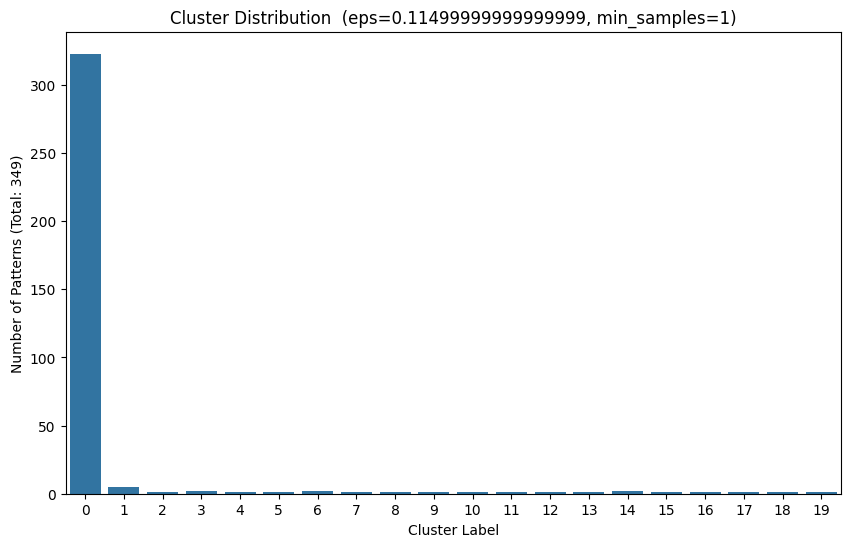

EPS: 0.12  / Min Samples: 1  / No of clusters: 12


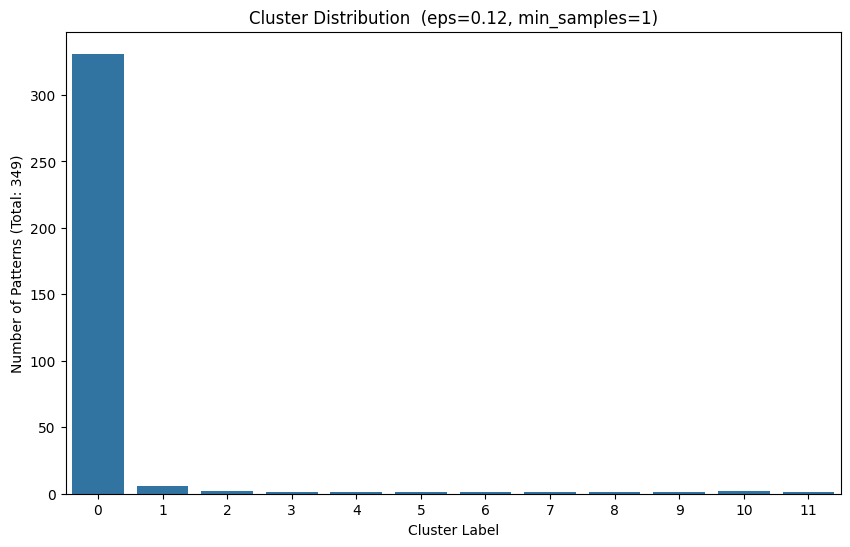

EPS: 0.125  / Min Samples: 1  / No of clusters: 7


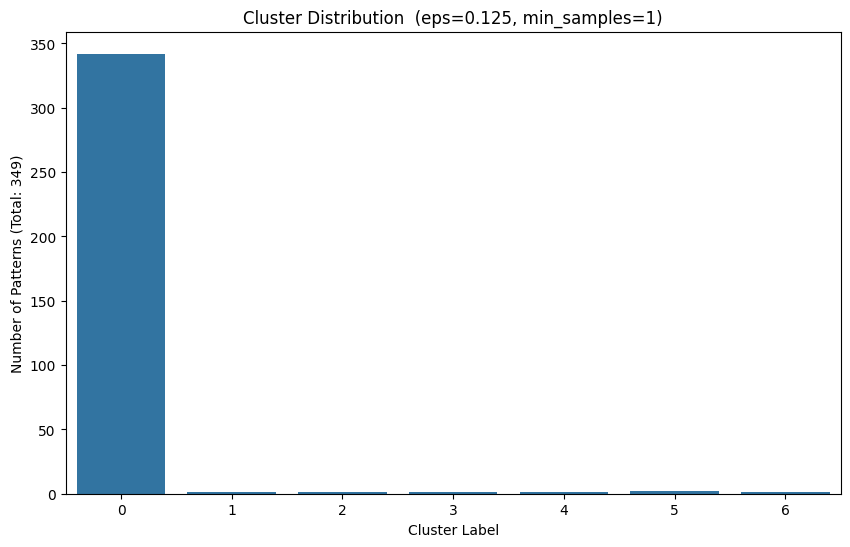

EPS: 0.13  / Min Samples: 1  / No of clusters: 4


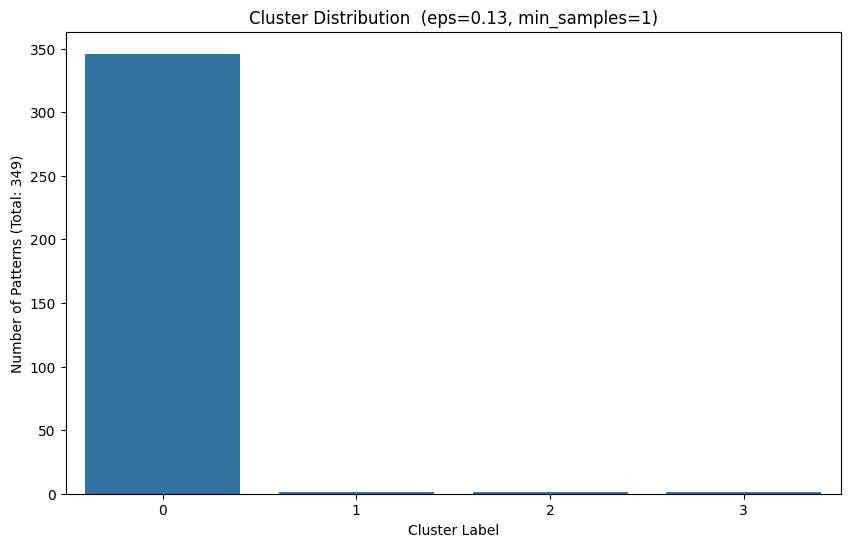

EPS: 0.135  / Min Samples: 1  / No of clusters: 3


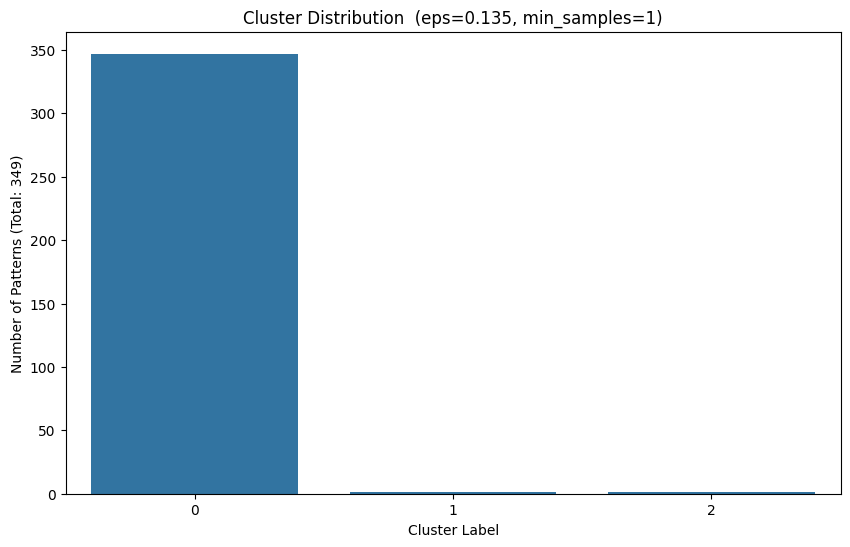

In [55]:
for i in range(10):
    build_cluster_chart(eps=0.09+i*0.005,min_samples=1,emb=base_data[features_cols], tag="")

In [ ]:
def build_cluster_chart_kmeans(n_clusters=5, emb=embeddings, tag=""):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(emb)

    print("No of clusters:", len(set(clusters.tolist())))

    plt.figure(figsize=(10,6))
    sns.countplot(x=clusters)
    plt.title(f"Cluster Distribution {tag} (n_clusters={n_clusters})")
    plt.xlabel("Cluster Label")
    plt.ylabel(f"Number of Patterns (Total: {len(emb)})")
    plt.show()
    BGM_df = base_data.copy()
    BGM_df["cluster"] = clusters
    for i,group in BGM_df.groupby("cluster"):
        print(f"Cluster {i}: {len(group)} patterns")
        for _,row in group.iterrows():
            print(f" - {row['Pattern Name']}")

No of clusters: 70


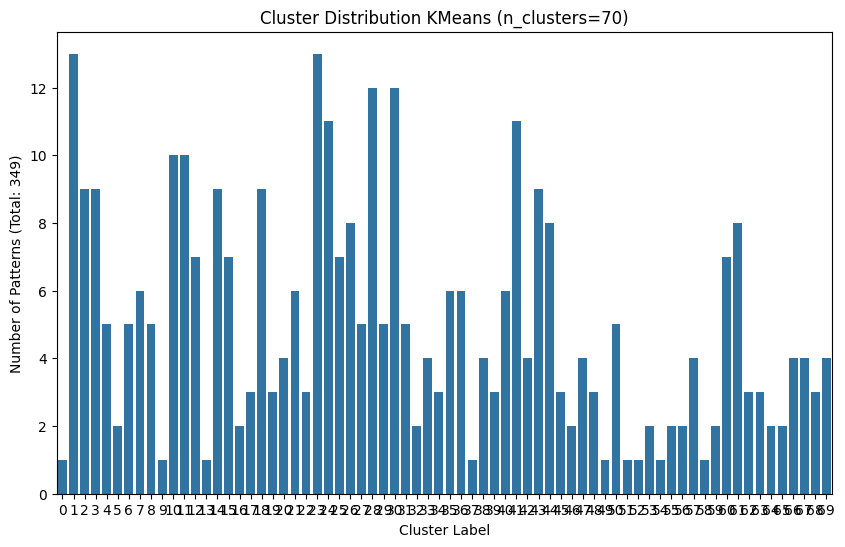

Cluster 0: 1 patterns
 - Round-Trip Consistency Filtering (for Synthetic Data)
Cluster 1: 13 patterns
 - Plan-and-Solve Paradigm
 - Decomposed Prompting (DecomP)
 - Two-LLM Framework for Reasoning Step Selection and Generation
 - Structured Output / Plan Generation
 - Planning
 - Rephrase and Respond (RaR)
 - Rereading (RE2)
 - StepBack Prompting
 - LeasttoMost Prompting
 - PlanandSolve Prompting
 - Cumulative Reasoning
 - DemonstrateSearchPredict (DSP)
 - Prompt Chain
Cluster 2: 9 patterns
 - SelfRefine
 - Iterative Prompting (for MT)
 - Iterative Self-Correction with Automated Feedback
 - Contextual Prompt Engineering
 - Hybrid Utility Function Design
 - Progressive Response Disclosure
 - Human Feedback for Quality Optimization (Reward Modeling & RLHF)
 - Rejection Sampling (Best-of-N)
 - KL Regularization in RLHF
Cluster 3: 9 patterns
 - Unified Ranking and Generation Instruction Tuning (RankRAG)
 - Retrieve-Rerank-Generate Inference Pipeline
 - Unified Instruction Format for Multi-

In [78]:
build_cluster_chart_kmeans(n_clusters=70,emb=base_data[features_cols], tag="KMeans")

No of clusters: 65


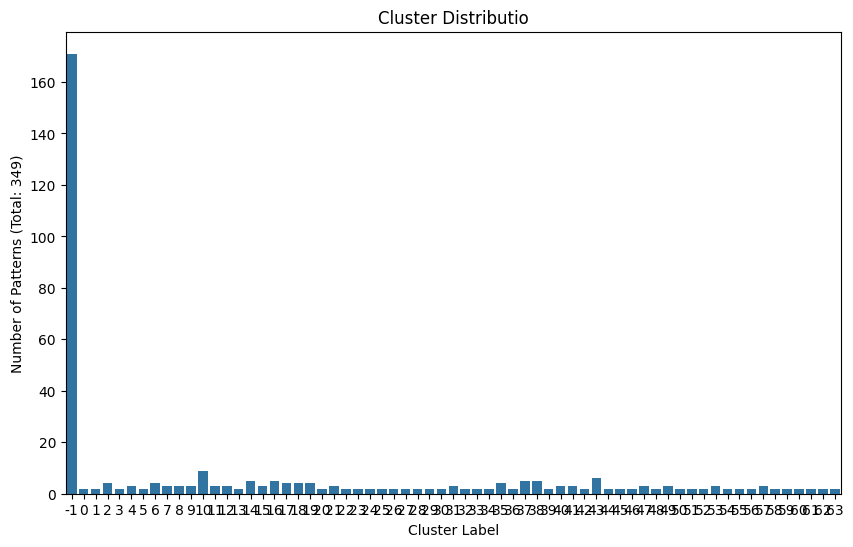

In [107]:
from sklearn.cluster import OPTICS
emb = base_data[features_cols]
model = OPTICS(min_samples=2, xi=0.01, min_cluster_size=0.005)
clusters = model.fit_predict(emb)

print("No of clusters:", len(set(clusters.tolist())))

plt.figure(figsize=(10,6))
sns.countplot(x=clusters)
plt.title(f"Cluster Distributio")
plt.xlabel("Cluster Label")
plt.ylabel(f"Number of Patterns (Total: {len(emb)})")
plt.show()

No of clusters: 70


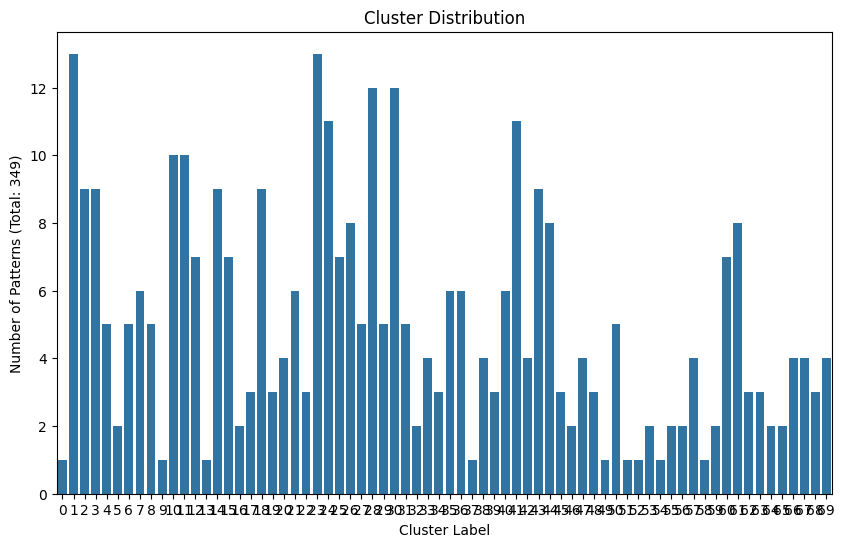

In [67]:
from sklearn.mixture import BayesianGaussianMixture
emb = base_data[features_cols]
model = BayesianGaussianMixture(
    n_components=70,  # upper limit, actual number is learned
    covariance_type='full',
    random_state=42
)
clusters = model.fit_predict(emb)

print("No of clusters:", len(set(clusters.tolist())))

plt.figure(figsize=(10,6))
sns.countplot(x=clusters)
plt.title(f"Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel(f"Number of Patterns (Total: {len(emb)})")
plt.show()

In [71]:
BGM_df = base_data.copy()
BGM_df["cluster"] = clusters

In [72]:
for i,group in BGM_df.groupby("cluster"):
    print(f"Cluster {i}: {len(group)} patterns")
    for _,row in group.iterrows():
        print(f" - {row['Pattern Name']}")

Cluster 0: 1 patterns
 - Round-Trip Consistency Filtering (for Synthetic Data)
Cluster 1: 13 patterns
 - Plan-and-Solve Paradigm
 - Decomposed Prompting (DecomP)
 - Two-LLM Framework for Reasoning Step Selection and Generation
 - Structured Output / Plan Generation
 - Planning
 - Rephrase and Respond (RaR)
 - Rereading (RE2)
 - StepBack Prompting
 - LeasttoMost Prompting
 - PlanandSolve Prompting
 - Cumulative Reasoning
 - DemonstrateSearchPredict (DSP)
 - Prompt Chain
Cluster 2: 9 patterns
 - SelfRefine
 - Iterative Prompting (for MT)
 - Iterative Self-Correction with Automated Feedback
 - Contextual Prompt Engineering
 - Hybrid Utility Function Design
 - Progressive Response Disclosure
 - Human Feedback for Quality Optimization (Reward Modeling & RLHF)
 - Rejection Sampling (Best-of-N)
 - KL Regularization in RLHF
Cluster 3: 9 patterns
 - Unified Ranking and Generation Instruction Tuning (RankRAG)
 - Retrieve-Rerank-Generate Inference Pipeline
 - Unified Instruction Format for Multi-

### PCA,UMAP and Cluster